# Initial Processing of the GEX Data 

This is the processing for the mRNA of the AMO experiment. In order to better identify ambient RNA, for this assay we experimented with spiking in mouse cells into the human cell mixture right before loading. During running of the 10x, had a _slight_ wetting failure. Because of this wetting failure on well 5, the ranked UMI plot doesn't look as nice as it should. For that reason, in the beginning of the notebook, I use the mouse transcripts in order to reliably call human cells. After this, I do regular processing and discover that the well that had the wetting failure seems to mostly produce cells that cluster with the normal populations, but there is one relatively large population that seems to be coming from well 5. This is a caveat of this data, but we accept it and do not analyze the data any further than the clustering and visualization.

# Setup

In [2]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm.notebook import tqdm

import warnings
import itertools as it
import json
import pickle as pkl
import os
import gzip

from clue_helper import sctools
from clue_helper import demux as clue_demux
from clue_helper import utils as clue_utils
from clue_helper import detools

In [3]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=16

In [4]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['savefig.facecolor'] = (1, 1, 1, 0)

In [5]:
mountpoint = '/data/clue_test/'
prefix_amo = mountpoint + 'amo/'
prefix_adts = prefix_amo + 'adts/'
prefix_mrna = prefix_amo + 'mrna/'
prefix_atac = prefix_amo + 'atac/'
prefix_figs = mountpoint + 'figs/'

## Load in the Data

In [5]:
wells = dict()
for well in range(1,6):
    wells[well] = dict()
    wells[well]['adata_h'] = sc.read_10x_h5(prefix_mrna + "cr/well%s/outs/raw_feature_bc_matrix.h5" % well, genome='hg38')
    wells[well]['adata_h'].var_names_make_unique()
    wells[well]['adata_m'] = sc.read_10x_h5(prefix_mrna + "cr/well%s/outs/raw_feature_bc_matrix.h5" % well, genome='mm10')
    wells[well]['adata_m'].var_names_make_unique()

reading /data/clue_test/amo/mrna/cr/well1/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:09)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /data/clue_test/amo/mrna/cr/well1/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:09)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /data/clue_test/amo/mrna/cr/well2/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:09)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /data/clue_test/amo/mrna/cr/well2/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:09)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /data/clue_test/amo/mrna/cr/well3/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:09)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /data/clue_test/amo/mrna/cr/well3/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:09)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /data/clue_test/amo/mrna/cr/well4/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:09)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /data/clue_test/amo/mrna/cr/well4/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:09)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /data/clue_test/amo/mrna/cr/well5/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:10)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading /data/clue_test/amo/mrna/cr/well5/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:10)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Load in Colors

In [6]:
with open(mountpoint + 'meta.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['cond_colors']['hex']

# Processing

Remove cells and genes that contain 0 counts.

In [7]:
for well in wells:
    for adata in ['adata_h', 'adata_m']:
        sc.pp.filter_cells(wells[well][adata], min_counts=1)
        sc.pp.filter_genes(wells[well][adata], min_counts=1)
        wells[well][adata + '-filter_cells_n_counts'] = wells[well][adata].obs['n_counts'].sort_values(ascending=False)

filtered out 6020220 cells that have less than 1 counts
filtered out 12746 genes that are detected in less than 1 counts
filtered out 5347333 cells that have less than 1 counts
filtered out 12604 genes that are detected in less than 1 counts
filtered out 6184059 cells that have less than 1 counts
filtered out 13427 genes that are detected in less than 1 counts
filtered out 5376313 cells that have less than 1 counts
filtered out 12626 genes that are detected in less than 1 counts
filtered out 6141518 cells that have less than 1 counts
filtered out 13453 genes that are detected in less than 1 counts
filtered out 5280341 cells that have less than 1 counts
filtered out 12695 genes that are detected in less than 1 counts
filtered out 5924908 cells that have less than 1 counts
filtered out 12397 genes that are detected in less than 1 counts
filtered out 5514936 cells that have less than 1 counts
filtered out 12720 genes that are detected in less than 1 counts
filtered out 6000629 cells that 

## Knee plots

Here I'm line-plotting the ranked genes by each genome, but then scatter-plotting the equivalent UMIs of the opposite genome. This shows a really nice distinction between mouse and human cells, and mouse and human background transcripts.

  0%|          | 0/10 [00:00<?, ?it/s]

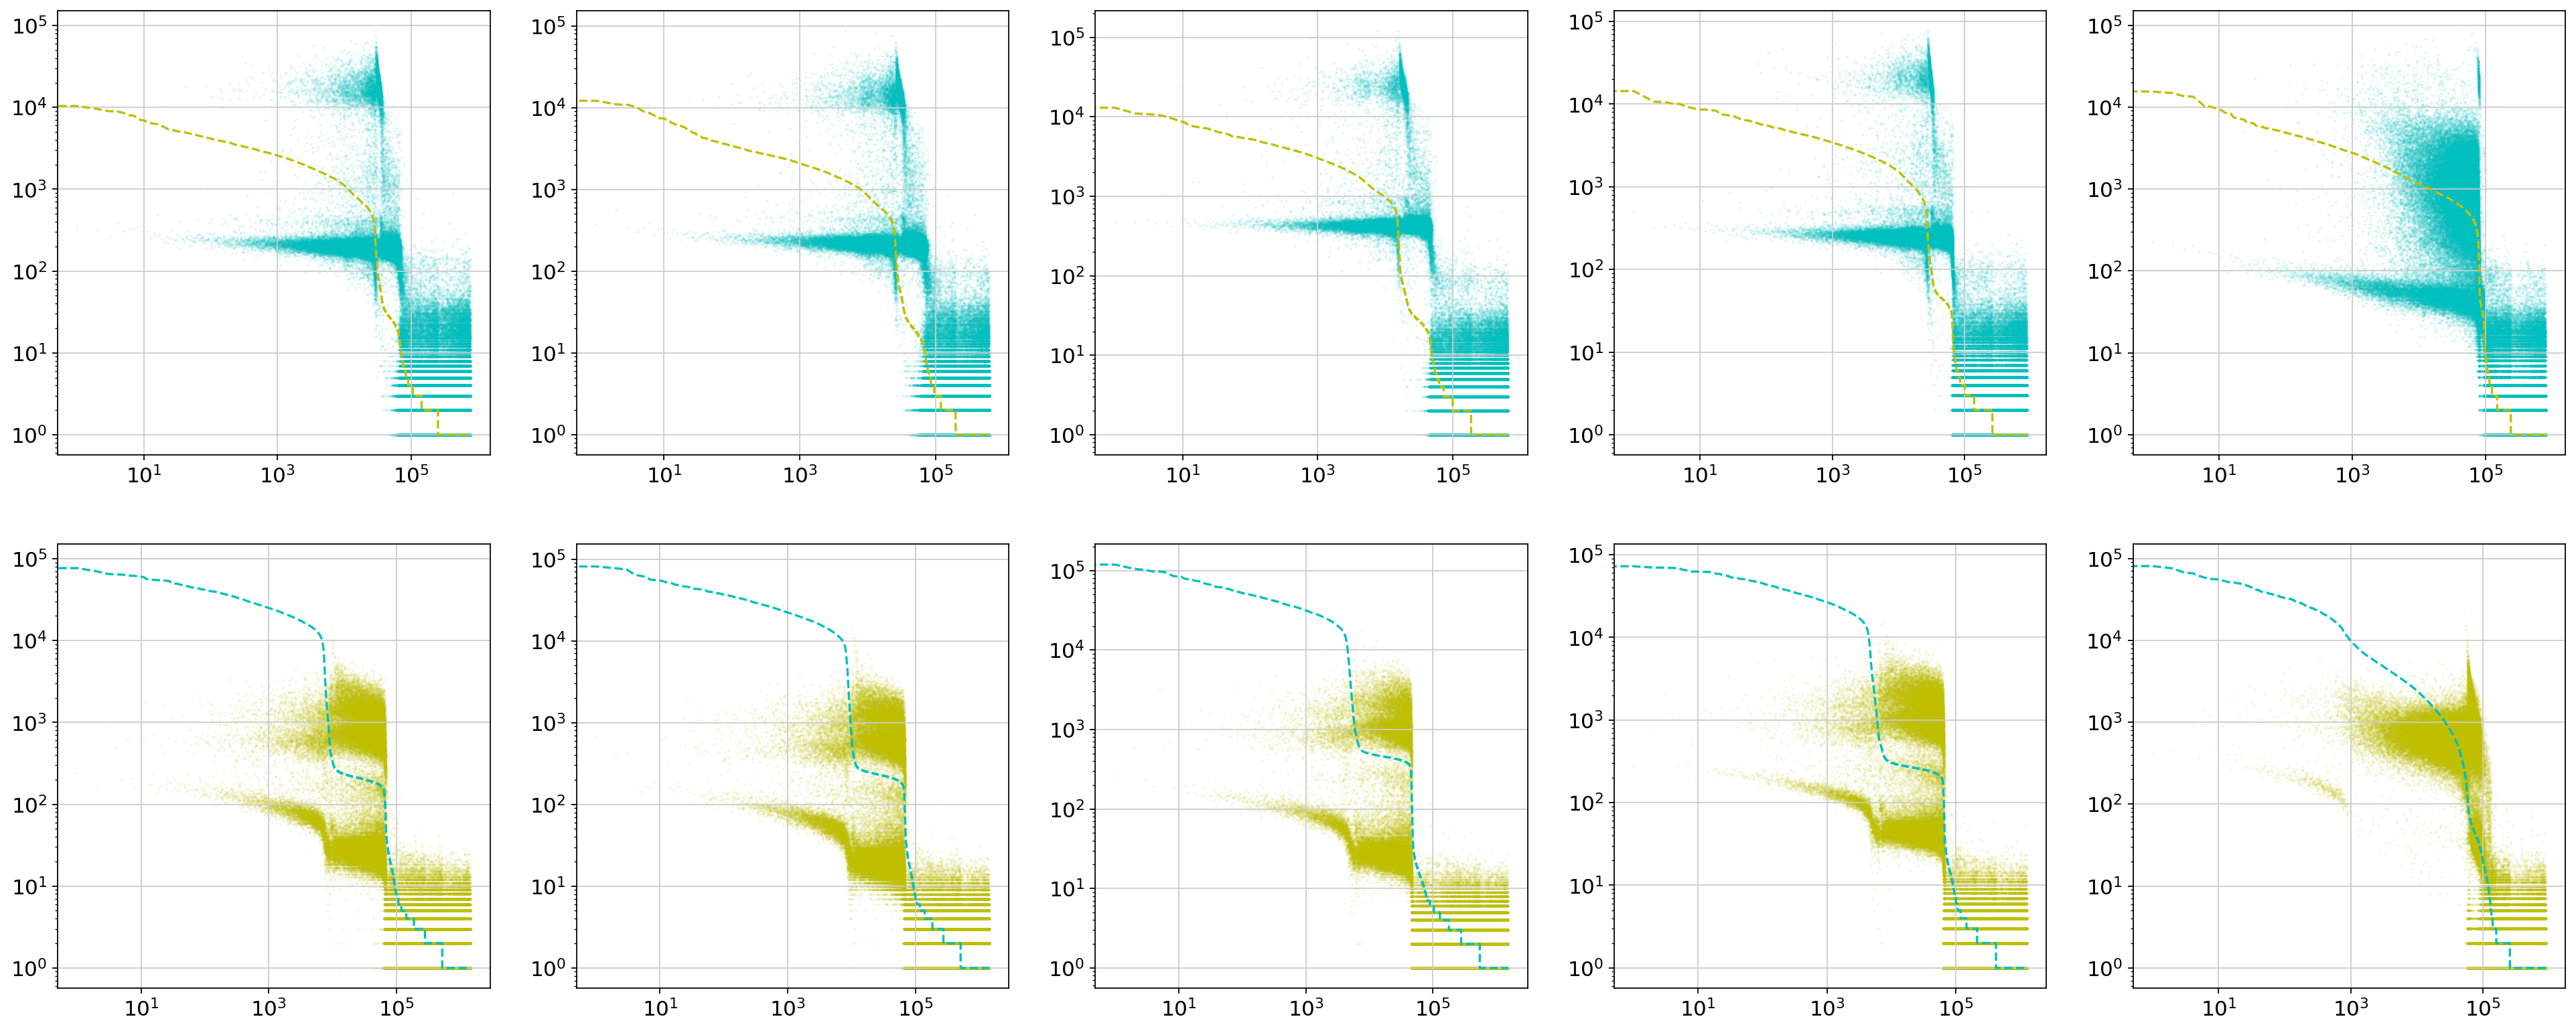

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(30,12))
for prod, ax in tqdm(list(zip(it.product(range(1,6), ['adata_h', 'adata_m']), np.ravel(ax.T))), total=10):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts']
    if prod[1] == 'adata_h':
        ax.scatter(range(len(series)), wells[prod[0]]['adata_m'].obs['n_counts'][series.index.values].values, color='c', alpha=0.1, s=3, linewidth=0)
        ax.plot(series.values, color='y', linestyle='--')
    else:
        ax.scatter(range(len(series)), wells[prod[0]]['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth=0)
        ax.plot(series.values, color='c', linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
# plt.tight_layout()

### Lower Gate
Let's take a closer look at the areas of interest:

In [9]:
lower_ranges = [(5e3, 4e4), (5e3, 4e4), (3e3, 3e4), (2e3, 3e4), (5.5e4, 1e5)]

  0%|          | 0/5 [00:00<?, ?it/s]

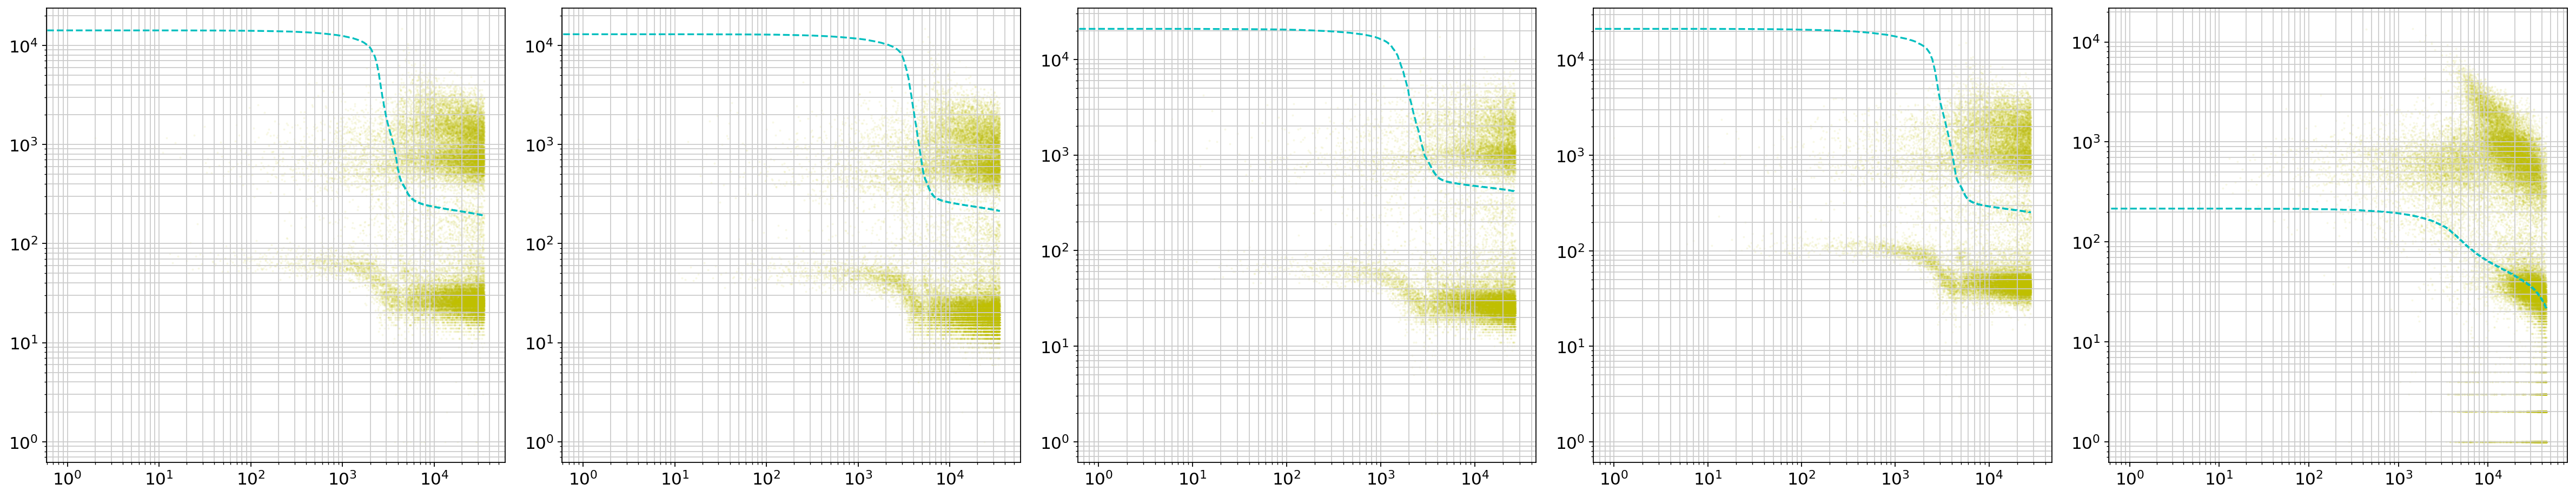

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(30,6))
for prod, ax, xlim in tqdm(list(zip(it.product(range(1,6), ['adata_m']), np.ravel(ax.T), lower_ranges)), total=5):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts'][int(xlim[0]):int(xlim[1])]
    ax.scatter(range(len(series)), wells[prod[0]]['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth=0)
    ax.plot(series.values, color='c', linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False) # turn off major, or else major will turn off while minor turns on
    ax.grid(which='both',axis='both')
plt.tight_layout()

In [11]:
lower_vlines = [4e3, 6e3, 3.5e3, 5e3, 6e3]

  0%|          | 0/5 [00:00<?, ?it/s]

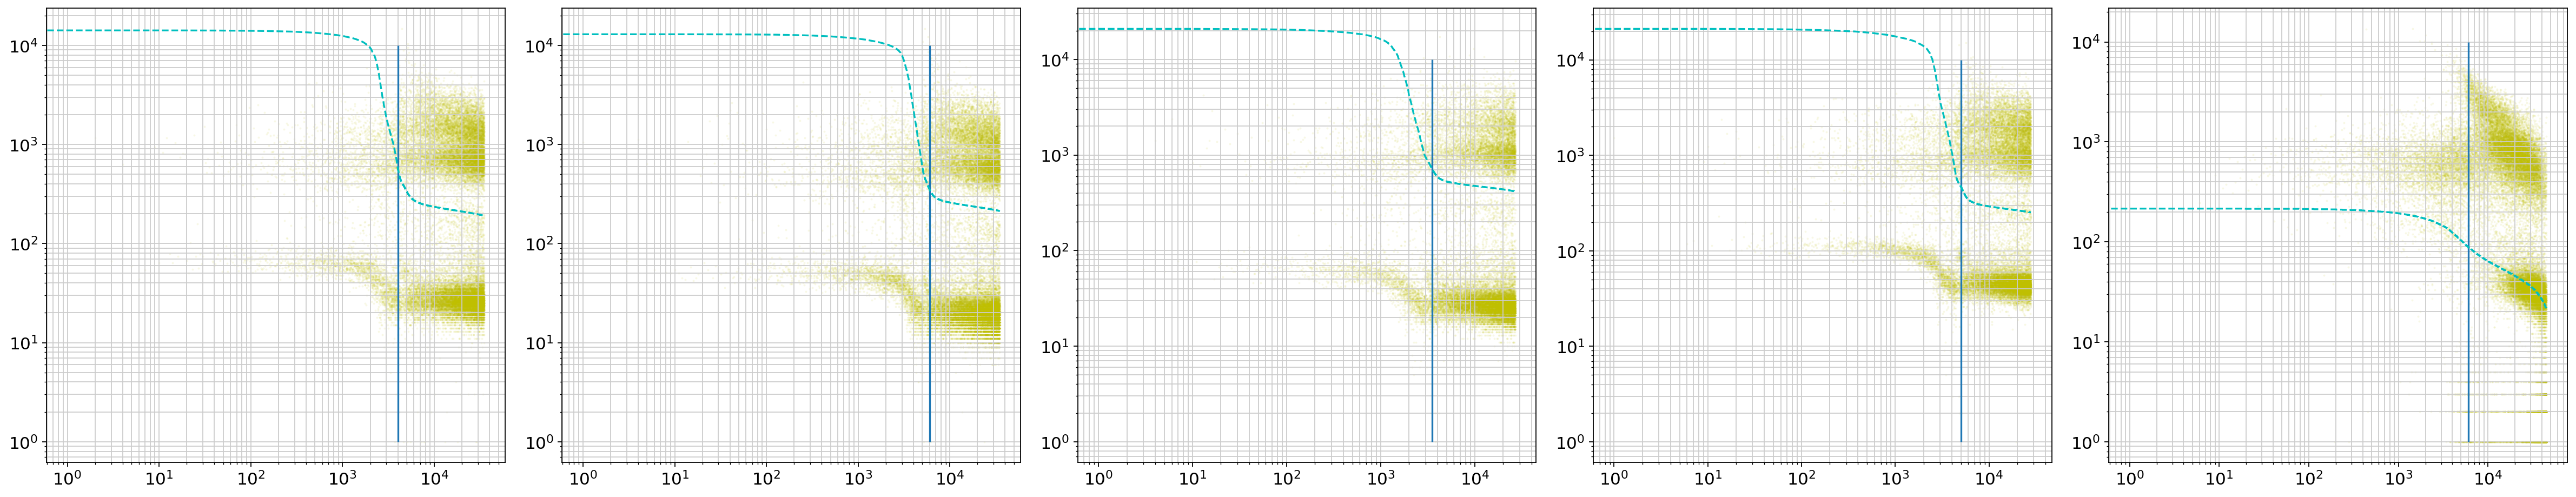

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(30,6))
for prod, ax, xlim, vline in tqdm(list(zip(it.product(range(1,6), ['adata_m']), np.ravel(ax.T), lower_ranges, lower_vlines)), total=5):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts'][int(xlim[0]):int(xlim[1])]
    ax.scatter(range(len(series)), wells[prod[0]]['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth=0)
    ax.plot(series.values, color='c', linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False) # turn off major, or else major will turn off while minor turns on
    ax.grid(which='both',axis='both')
    ax.vlines(vline, 1, 1e4)
plt.tight_layout()

### Upper Gate

In [13]:
upper_ranges = [(5e4, 9e4), (5e4, 9e4), (3e4, 6e4), (4e4, 8e4), (8e4, 2e5)]

  0%|          | 0/5 [00:00<?, ?it/s]

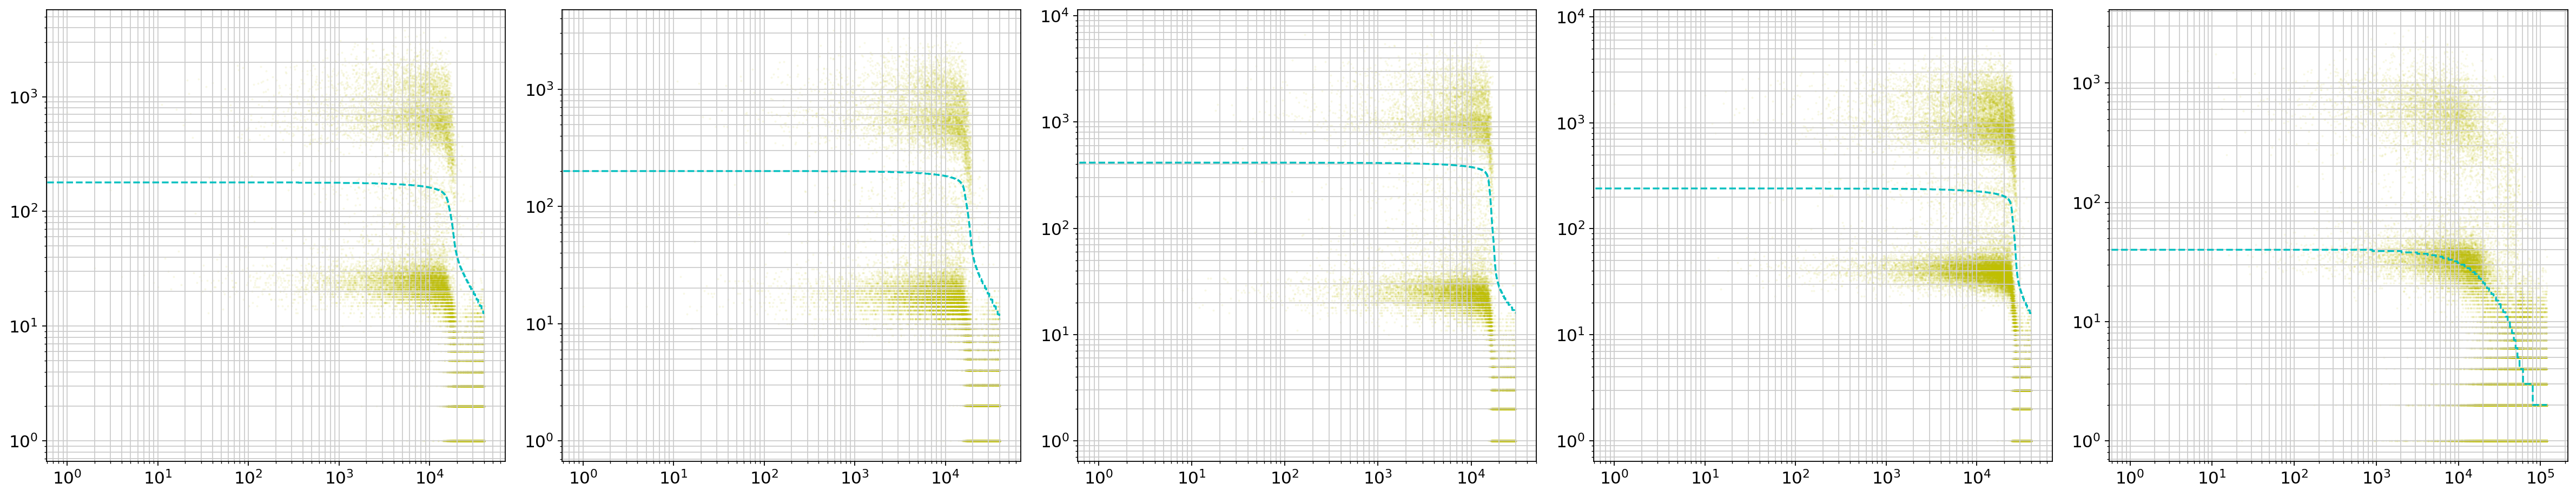

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(30,6))
for prod, ax, xlim in tqdm(list(zip(it.product(range(1,6), ['adata_m']), np.ravel(ax.T), upper_ranges)), total=5):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts'][int(xlim[0]):int(xlim[1])]
    ax.scatter(range(len(series)), wells[prod[0]]['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth=0)
    ax.plot(series.values, color='c', linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False) # turn off major, or else major will turn off while minor turns on
    ax.grid(which='both',axis='both')
plt.tight_layout()

In [15]:
upper_vlines = [1.5e4, 1.5e4, 1.4e4, 2.1e4, 2e4]

  0%|          | 0/5 [00:00<?, ?it/s]

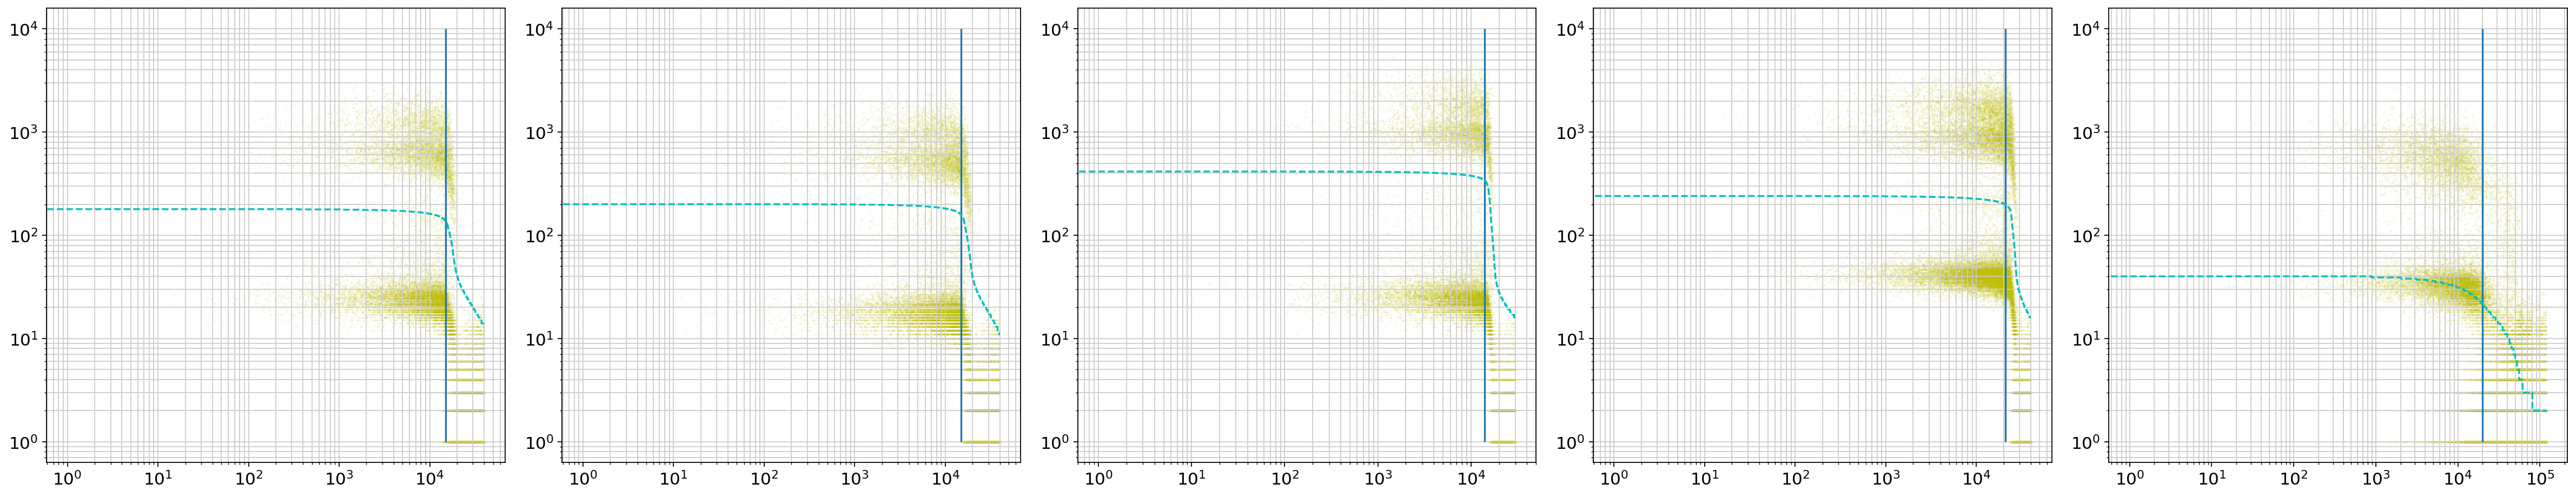

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(30,6))
for prod, ax, xlim, vline in tqdm(list(zip(it.product(range(1,6), ['adata_m']), np.ravel(ax.T), upper_ranges, upper_vlines)), total=5):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts'][int(xlim[0]):int(xlim[1])]
    ax.scatter(range(len(series)), wells[prod[0]]['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth=0)
    ax.plot(series.values, color='c', linestyle='--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False) # turn off major, or else major will turn off while minor turns on
    ax.grid(which='both',axis='both')
    ax.vlines(vline, 1, 1e4)
plt.tight_layout()

In [17]:
ranges = list()
for l_r, l_v, u_r, u_v in zip(lower_ranges, 
                              lower_vlines, 
                              upper_ranges, 
                              upper_vlines):
    ranges.append((l_r[0] + l_v, u_r[0] + u_v))

In [18]:
umi_cutoffs = [250, 250, 400, 400, 250]

  0%|          | 0/5 [00:00<?, ?it/s]

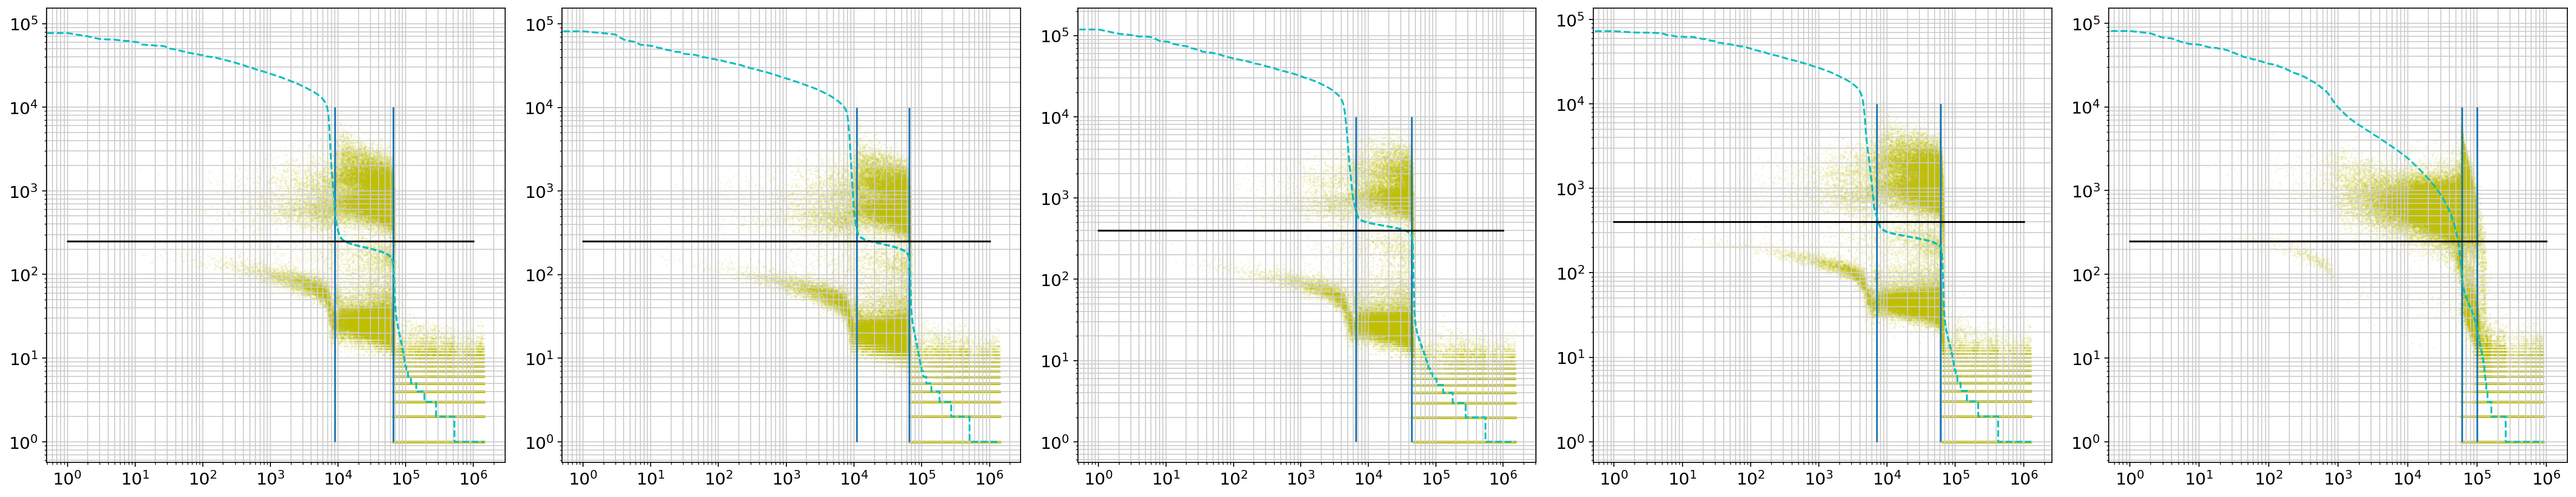

In [19]:
fig, ax = plt.subplots(1, 5, figsize=(30,6))
for prod, ax, xlim, umi_c in tqdm(list(zip(it.product(range(1,6), ['adata_m']), np.ravel(ax.T), ranges, umi_cutoffs)), total=5):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts']
    ax.scatter(range(len(series)), wells[prod[0]]['adata_h'].obs['n_counts'][series.index.values].values, color='y', alpha=0.1, s=3, linewidth=0)
    ax.plot(series.values, color='c', linestyle='--')
    ax.plot([1, 1e6], [umi_c, umi_c], color='k')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False) # turn off major, or else major will turn off while minor turns on
    ax.grid(which='both',axis='both')
    ax.vlines(xlim[0], 1, 1e4)
    ax.vlines(xlim[1], 1, 1e4)    
plt.tight_layout()

If you try to visualize mentally, the knee plot for the opposite genome is just a projection onto the Y axis of each plot. For the first 4 wells, this would actually capture most of the cells I'm capturing with the above visualization method. However, for well 5, that would grab a TON of what I think is background human RNA. We can salvage the data from that last well using this method because we're excluding that background.

## Remove Background

I would like to subset the drops and separate the drops into those with cells and those with background. Because there's so few in background as compare to droplets, I will simply drop those in the background from further processing.

In [20]:
for prod, xlim, umi_c in tqdm(list(zip(it.product(range(1,6), ['adata_m']), ranges, umi_cutoffs)), total=5):
    series = wells[prod[0]][prod[1] + '-filter_cells_n_counts'][int(xlim[0]):int(xlim[1])]
    
    # need to take overlap because there will be a few bad apples (min_count=0) that were removed from adata_h 
    overlap = np.intersect1d(series.index.values, wells[prod[0]]['adata_h'].obs_names, assume_unique=True)
    
    wells[prod[0]]['adata_h'] = wells[prod[0]]['adata_h'][overlap].copy()
    
    # make a new covariate in the obs
    background_list = list()
    for count in wells[prod[0]]['adata_h'].obs['n_counts']:
        if count < umi_c:
            background_list.append('True')
        else:
            background_list.append('False')
    wells[prod[0]]['adata_h'].obs['background'] = background_list

  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
for well in wells:
    print(well)
    print(wells[well]['adata_h'][wells[well]['adata_h'].obs['background'] == 'True'])
    print(wells[well]['adata_h'][wells[well]['adata_h'].obs['background'] == 'False'])
    print('')

1
View of AnnData object with n_obs × n_vars = 31608 × 20792
    obs: 'n_counts', 'background'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
View of AnnData object with n_obs × n_vars = 24347 × 20792
    obs: 'n_counts', 'background'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'

2
View of AnnData object with n_obs × n_vars = 33824 × 20111
    obs: 'n_counts', 'background'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
View of AnnData object with n_obs × n_vars = 20167 × 20111
    obs: 'n_counts', 'background'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'

3
View of AnnData object with n_obs × n_vars = 25093 × 20085
    obs: 'n_counts', 'background'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
View of AnnData object with n_obs × n_vars = 12406 × 20085
    obs: 'n_counts', 'background'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'

4
View of AnnData object with n_obs × n_vars = 31703 × 21141
    obs: 'n_counts

  0%|          | 0/5 [00:00<?, ?it/s]

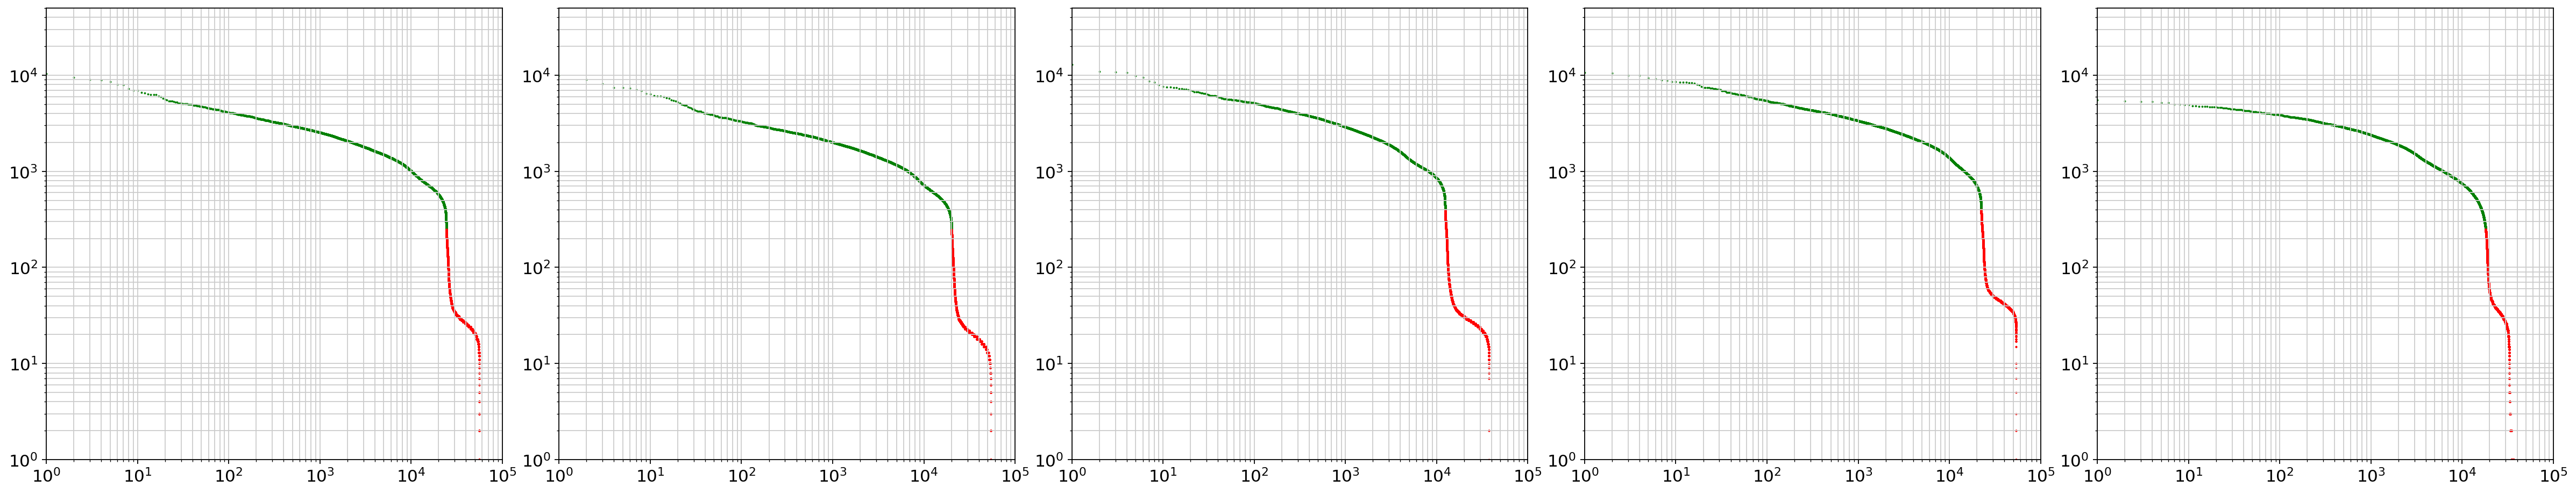

In [22]:
fig, ax = plt.subplots(1, 5, figsize=(30,6))
for well, ax in tqdm(list(zip(wells, np.ravel(ax.T)))):
    df = wells[well]['adata_h'].obs[['n_counts','background']].sort_values('n_counts', ascending=False).copy()
    df['rank'] = range(len(df))
    ax.scatter(df[df['background'] == 'False']['rank'].values, 
               df[df['background'] == 'False']['n_counts'].values, 
               color='g', s=3, linewidth=0)
    ax.scatter(df[df['background'] == 'True']['rank'].values, 
               df[df['background'] == 'True']['n_counts'].values, 
               color='r', s=3, linewidth=0)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(False) # turn off major, or else major will turn off while minor turns on
    ax.grid(which='both',axis='both') 
    ax.set_xlim(1,1e5)
    ax.set_ylim(1,5e4)
plt.tight_layout()

Make a new object for only filtered cells.

In [23]:
for well in wells:
    wells[well]['adata_filt'] = wells[well]['adata_h'][wells[well]['adata_h'].obs['background'] == 'False'].copy()
    wells[well]['adata_filt'].obs.drop('background', axis=1, inplace=True)

In [24]:
wells[1]['adata_filt']

AnnData object with n_obs × n_vars = 24347 × 20792
    obs: 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'

## Percent Mito Filtration

In [25]:
for well in wells:
    genelist = wells[well]['adata_filt'].var_names.tolist()
    mito_genes_names = [gn for gn in genelist if gn.startswith('hg38_______MT-')]
    mito_genes = [genelist.index(gn) for gn in mito_genes_names]
    mito_counts = np.ravel(np.sum(wells[well]['adata_filt'][:, mito_genes].X, axis=1))
    wells[well]['adata_filt'].obs['percent_mito'] = mito_counts / wells[well]['adata_filt'].obs['n_counts'].values

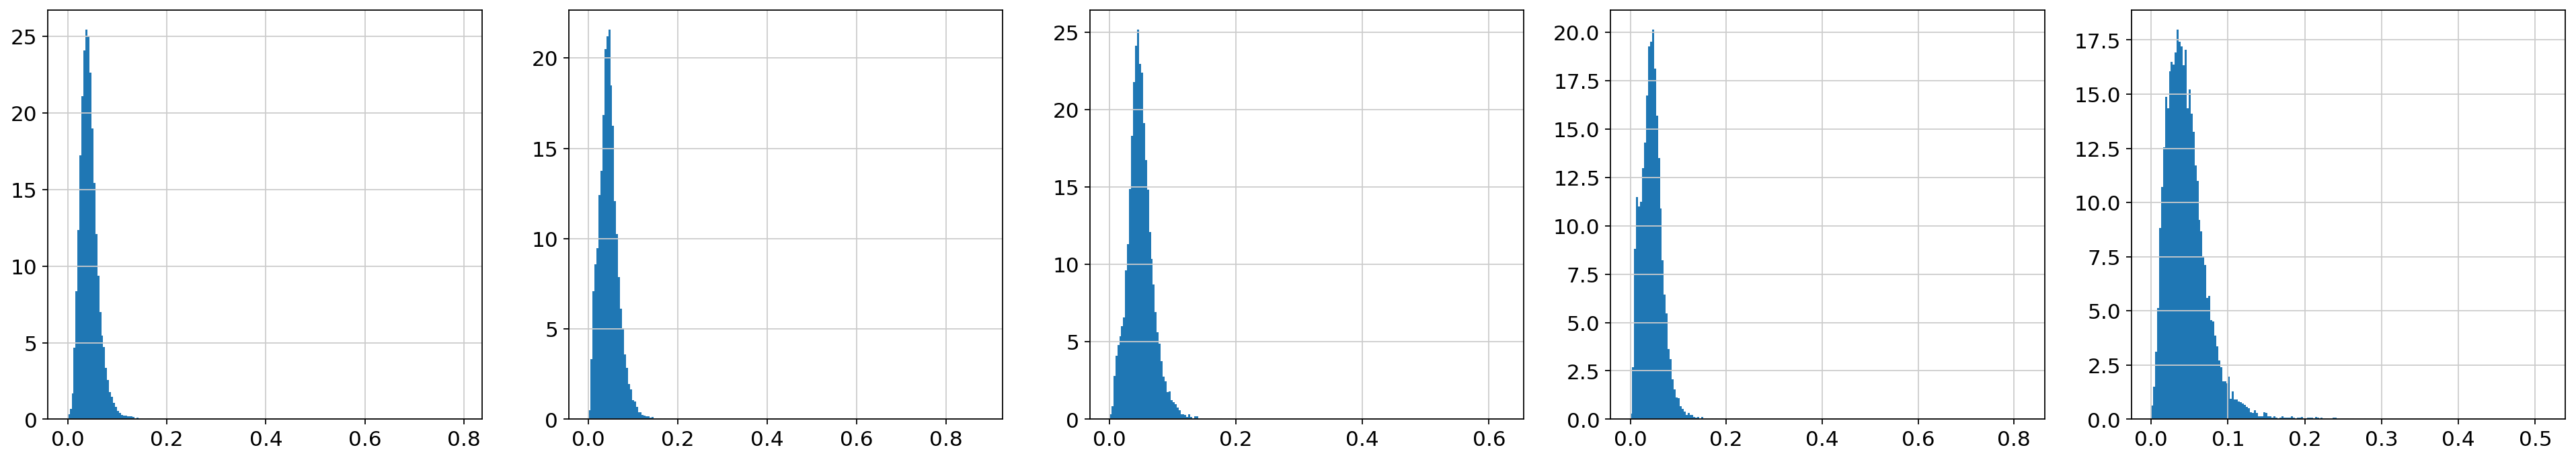

In [26]:
fig, ax = plt.subplots(1, 5, figsize=(30, 5))
for well, ax in zip(wells, ax):
    ax.hist(wells[well]['adata_filt'].obs['percent_mito'].values,bins=200,density=True);

In [27]:
for well in wells:
    wells[well]['adata_filt'] = wells[well]['adata_filt'][wells[well]['adata_filt'].obs['percent_mito'] < 0.1].copy()

Export the filtered barcodes for demuxlet:

In [28]:
# for well in wells:
#     with open(prefix_mrna + 'vals/well%s_filt_bcs.tsv' % well,'w') as file:
#         for obs in wells[well]['adata_filt'].obs_names:
#             file.write(obs + '\n')

# Import `popscle` Results

I merged all the bams and changed the gem-group number at the end of the barcodes. I then ran freemuxlet using the list of good sites from Hyun. First, I will split up the output according to the wells it came from:

In [29]:
wellsplit = dict()
wellsplit_dir = prefix_mrna + 'demultiplex/freemux/wellsplit/'
if not os.path.exists(wellsplit_dir):
    os.mkdir(wellsplit_dir)
for well in range(1, 6):
    wellsplit[well] = open(wellsplit_dir + 'well%d.samples' % well, 'w')
with gzip.open(prefix_mrna + 'demultiplex/freemux/freemux.clust1.samples.gz', 'rt') as file:
    header = file.readline()
    for well in range(1, 6):
        wellsplit[well].write(header)
    for line in file:
        bc = line.split('\t')[1]
        well = int(bc.split('-')[-1])
        wellsplit[well].write(line)
for well in range(1, 6):
    wellsplit[well].close()

In [30]:
for well in wells:
    wells[well]['freemux'] = clue_demux.MuxOut(wellsplit_dir + 'well%s.samples' % well)

In [31]:
deconvolution = pd.DataFrame(index=range(1,6), columns=[str(i) for i in range(5)])

In [32]:
for i in deconvolution.index:
    for c in deconvolution.columns:
        deconvolution.loc[i, c] = sum(wells[i]['freemux'].sng()['BEST.GUESS'] == c)

In [33]:
deconvolution

0     1     2     3     4
1  6002  6022     7  4583  2905
2  5851  3108  4441  3394     4
3  3786     0  3758  1166  1917
4  4538  4229  5478     0  3842
5    21  3571  2103  1438  1986

In [34]:
# deconvolution.to_csv(prefix_mrna + 'vals/deconvolution_mrna.csv')

In [35]:
norm = mpl.colors.TwoSlopeNorm(vcenter=1000, vmin=0, vmax=6000)

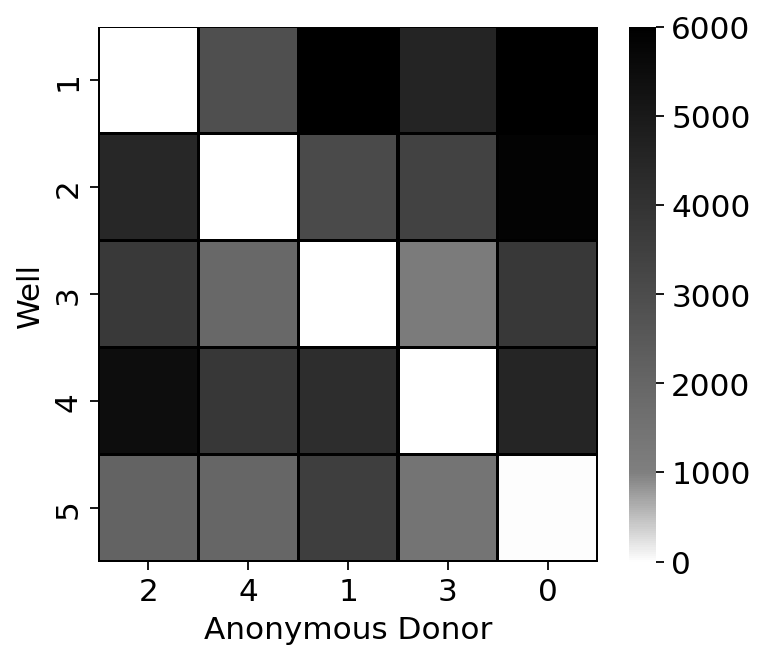

In [36]:
plt.figure(figsize=(5,4.4))
sns.heatmap(deconvolution[['2', '4', '1', '3', '0']].astype(int), norm=norm,
            linewidths=1, linecolor='black', cmap='binary');
plt.ylabel('Well')
plt.xlabel('Anonymous Donor');

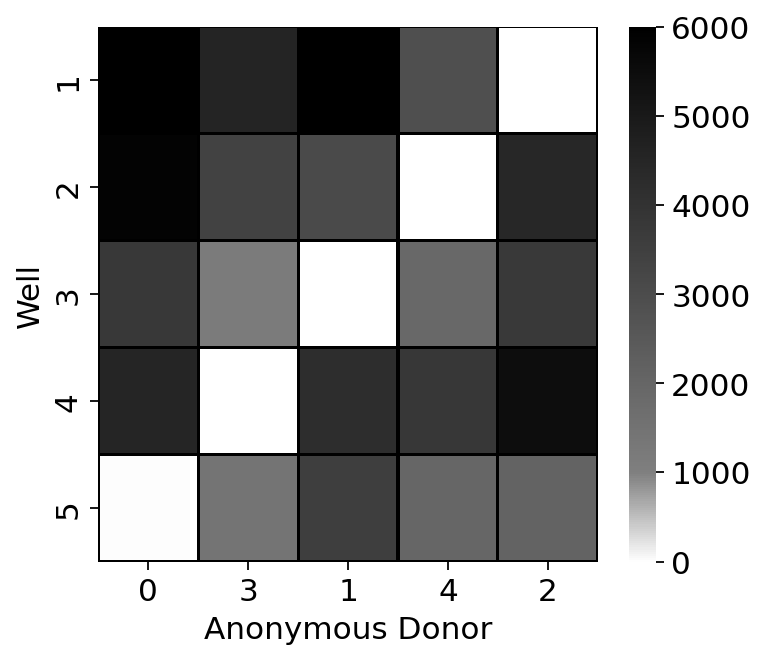

In [37]:
plt.figure(figsize=(5,4.4))
sns.heatmap(deconvolution[['0', '3', '1', '4', '2']].astype(int), norm=norm,
            linewidths=1, linecolor='black', cmap='binary');
plt.ylabel('Well')
plt.xlabel('Anonymous Donor');

In [38]:
scheme = pd.read_csv(prefix_amo + 'vals/scheme.csv')

In [39]:
norm = mpl.colors.TwoSlopeNorm(vcenter=2000, vmin=0, vmax=6000)

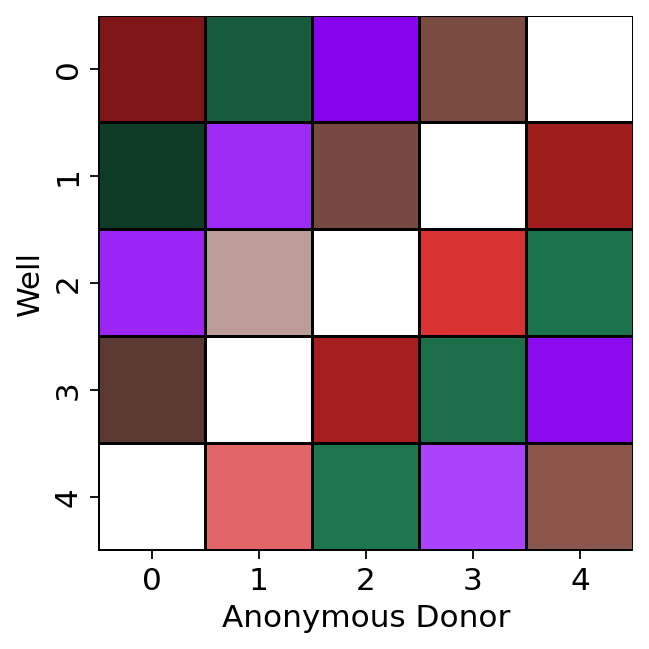

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5,4.4))
for color in ['0', 'C', 'G', 'B', 'P']:
    dark_color = clue_utils.adj_light(cond_colors[color], 1.4)
    ax = sns.heatmap(np.where(scheme == color, deconvolution[['0', '3', '1', '4', '2']].astype(int), np.nan), norm=norm, 
                linewidths=1, linecolor='black', cbar=False, square=True,
                cmap = mpl.colors.LinearSegmentedColormap.from_list(color, [[1,1,1], cond_colors[color], dark_color], N=100),
                ax=ax
               );
plt.ylabel('Well')
plt.xlabel('Anonymous Donor');

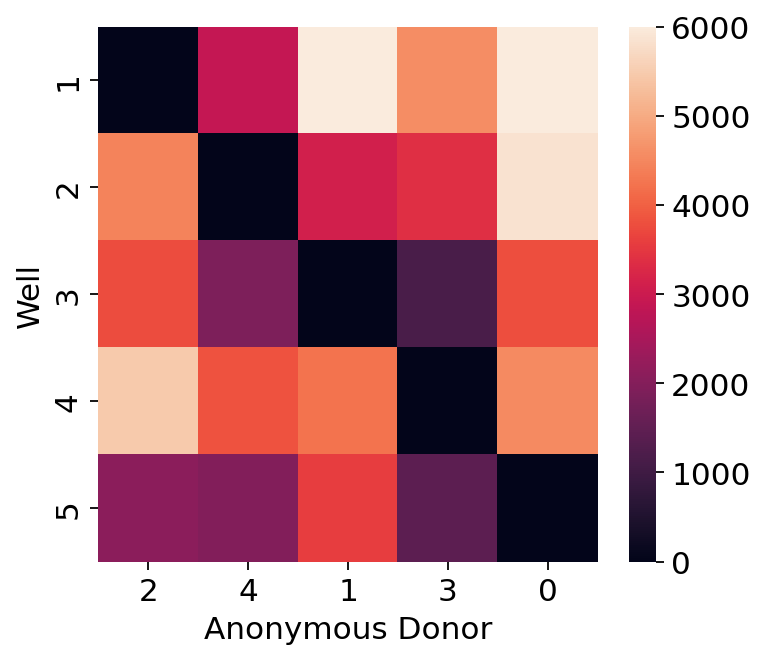

In [41]:
plt.figure(figsize=(5,4.4))
sns.heatmap(deconvolution[['2', '4', '1', '3', '0']].astype(int), vmin=0, vmax=6000);
plt.ylabel('Well')
plt.xlabel('Anonymous Donor');

High signal to noise of off diagonal-to-diagonal elements shows that the AMO scheme works. Now to attach covariates to the donors and then stimulation conditions.

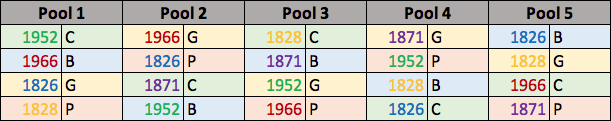

So, based on our scheme, it looks like these are the mappings, in order from 0 to 4:

In [42]:
donor_map = ['52', '26', '71', '66', '28']

In [43]:
# mismaps are represented by 0
condition_map = {1: ['C', 'G', '0', 'B', 'P'],
                 2: ['B', 'P', 'C', 'G', '0'], 
                 3: ['G', '0', 'B', 'P', 'C'], 
                 4: ['P', 'C', 'G', '0', 'B'], 
                 5: ['0', 'B', 'P', 'C', 'G']}

And now, lets generate some covariate DataFrames so we can merge it onto the data.

In [44]:
for well in wells:
    wells[well]['covar_df'] = pd.DataFrame(index=[str(i) for i in range(5)], columns=['ind','cond'])
    wells[well]['covar_df']['ind'] = donor_map
    wells[well]['covar_df']['cond'] = condition_map[well]

I changed the barcode names at the command line to align the well numbers. Here I rename them to match.

In [45]:
for well in wells:
    wells[well]['adata_filt'].obs_names = [i[:16] + '-%s' % well for i in wells[well]['adata_filt'].obs_names]

In [46]:
for well in wells:
    wells[well]['adata_sng'] = clue_demux.ann_merge(wells[well]['adata_filt'], wells[well]['freemux'].sng(), covars=wells[well]['covar_df'])

In [47]:
concat = wells[1]['adata_sng'].concatenate(wells[2]['adata_sng'], 
                                           wells[3]['adata_sng'], 
                                           wells[4]['adata_sng'], 
                                           wells[5]['adata_sng'])

In [48]:
concat.var['n_counts'] = concat.var[[i for i in concat.var.columns if i.startswith('n_counts')]].sum(axis=1)

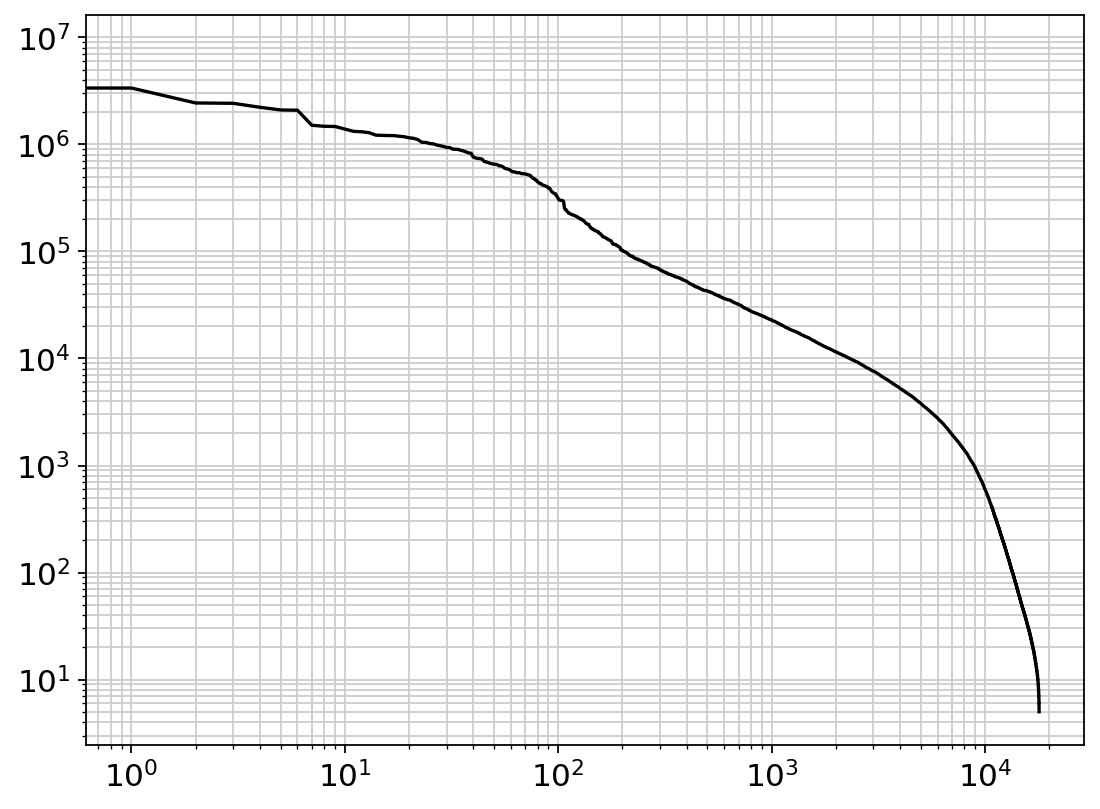

In [49]:
plt.figure(figsize=(8,6))
plt.plot(range(len(concat.var_names)), 
         concat.var['n_counts'].sort_values(ascending=False).values, 
         color='k')
plt.grid(False)
plt.grid(True, 'both', 'both')
plt.xscale('log')
plt.yscale('log')

In [50]:
# remove any genes that are now empty
sc.pp.filter_genes(concat, min_counts=20)

filtered out 2984 genes that are detected in less than 20 counts


In [51]:
concat.var_names = [i[11:] for i in concat.var_names] # get rid of the hg38_______

In [52]:
path = prefix_mrna + 'h5ads/concat_1.h5ad'

# concat.write_h5ad(path)
concat = sc.read_h5ad(path)

# Dimensionality Reduction and Clustering

Below, I ran dimensionality reduction and clustering. Because of the stochastic nature of UMAP, re-running the cells might yield different results each time. I have noticed that even with Scanpy's random seeding implementation, I still get different results from run-to-run . Therefore, I keep the cells here to show the steps I did to create the `concat_2.h5ad` object. But to match exactly what is shown in the paper, I suggest simply loading in the h5ad file further down below. 

In [ ]:
sc.pp.filter_genes(concat, min_counts=1, inplace=True) # keep as many genes as possible
sc.pp.normalize_per_cell(concat, counts_per_cell_after=1e6)
sc.pp.log1p(concat)
sc.pp.scale(concat)
sc.pp.combat(concat, key='batch')
sc.pp.scale(concat)
sc.pp.pca(concat, n_comps=100)

In [ ]:
sc.pl.pca_variance_ratio(concat,log=True, n_pcs=100)

In [ ]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(concat, n_neighbors=15, n_pcs=60, random_state=0) # using all available embeddings, numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

In [ ]:
sc.tl.umap(concat, random_state=0)

In [ ]:
sc.tl.leiden(concat, resolution=0.2, random_state=0)

In [ ]:
concat.uns['cond_colors'] = [cond_colors[i] for i in concat.obs['cond'].cat.categories]

In [ ]:
sc.pl.umap(concat,color=['leiden', 'percent_mito', 'cond', 'n_counts'], size=5);

In [ ]:
batches = concat.obs['batch'].unique() # get a list of the batches
# make a new column in the `.obs` for each batch that is of dtype `int` and that just takes on values of 0 and 1 so that it gets plotted as a continuous variable instead of a categorical one
for batch in batches:
    concat.obs['batch_%s' % batch] = (concat.obs['batch'] == batch).astype(int)

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20,3.5))
# make a new column in the `.obs` for each batch that is of dtype `int` so that it gets plotted as a continuous variable instead of a categorical one
for batch, ax in zip(batches, np.ravel(ax)):
    ax.set_facecolor('gray')
    sc.pl.umap(concat, color=['batch_%s' % batch], ax=ax, sort_order=True, show=False, return_fig=False)

There is a lone cluster coming from well 5 (`batch_4`). Even well 4 (`batch_3`) is showing some polarization within clusters as well. I will dive a bit deeper into that cluster. First let's see which genes are specifically marking it.

# Differential Expression

In [ ]:
# sc.settings.verbosity = 4
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat, groupby='leiden', method='t-test')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat, ncols=5)
sc.settings.verbosity = 4

In [ ]:
sc.pl.umap(concat,color=[i for i in concat.uns['rank_genes_groups']['names']['5'][:16]], size=5);

It looks like it expresses many markers unique to the myeloid cells, but also IL2 which seems to be unique to that T cell PMA cluster up top. Seems like just low quality droplets with a mess of different transcripts, likely from the wetting failure. 

# Subcluster

In [ ]:
sub_concats = dict() # put the new subsetted concat objects in a dictionary of concats
for i in ['9']:
    sub_concats[i] = concat[concat.obs['leiden'] == i].copy()

In [ ]:
sc.tl.leiden(sub_concats['9'], resolution=0.2) # subcluster them using Leiden
sc.pl.umap(sub_concats['9'], color='leiden', size=15)

Map them back to the clusters on the original `adata`.

In [ ]:
concat = nr.subcluster_mapper(concat, sub_concats)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.umap(concat, color=['leiden'], ax=ax, size=15, legend_loc='on data', palette=sc.pl.palettes.default_20)

In [ ]:
nr.prop_col_chart(concat, group='cond', x='leiden', norm=True, prop=False);

In [ ]:
nr.prop_col_chart(concat, group='cond', x='leiden', norm=False, prop=False);

In [ ]:
nr.prop_col_chart(concat, group='batch', x='leiden', norm=False, prop=False);

We see that although there are very few mis-mappings (`'0'`) in total, they are disproportionately represented in cluster 5, which is almost entirely derived from `batch_4`. I will therefore remove this cluster and the mis-mapped observations.

In [ ]:
concat = concat[concat.obs['leiden'] != '5'].copy() 
concat = concat[concat.obs['cond'] != '0'].copy() 

## Export concat_2.h5ad

In [6]:
path = prefix_mrna + 'h5ads/concat_2.h5ad'

# concat.write_h5ad(path)
concat = sc.read_h5ad(path)

OSError: Unable to open file (unable to open file: name = '/data/clue_test/amo/mrna/h5ads/concat_2.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
nr.relabel_clusts(concat)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.umap(concat, color=['leiden'], ax=ax, size=15, legend_loc='on data')

In [ ]:
concat_C = concat[concat.obs['cond'] == 'C'].copy()
vcounts = concat_C.obs['leiden'].value_counts()
drop = vcounts.index[vcounts < 30]
concat_C = concat_C[~concat_C.obs['leiden'].isin(drop)].copy()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sc.pl.umap(concat_C, color=['leiden'], ax=ax, size=15, legend_loc='on data')

In [ ]:
# sc.settings.verbosity = 4
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat_C, groupby='leiden')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat_C, ncols=5)
sc.settings.verbosity = 4

In [ ]:
# sc.settings.verbosity = 4
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat, groupby='leiden', method='t-test')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat, ncols=5)
sc.settings.verbosity = 4

Assign clusters as cell types.

In [ ]:
ct_mapper = {'0': 'T_cells',
             '1': 'myeloid_cells',
             '2': 'T_NK',
             '3': 'NK_T_Tox',
             '4': 'B_cells',
             '5': 'T_Act',
             '6': 'B_cells',
             '7': 'myeloid_cells',
             '8': 'myeloid_cells', # pDCs
             '9': 'myeloid_cells', # pDCs
             '10': 'HSC',
             '11': 'PLT'
            }

In [ ]:
concat.obs['ct1'] = concat.obs['leiden'].map(ct_mapper).astype('category')
concat.obs['ct1'] = concat.obs['ct1'].cat.reorder_categories(['B_cells', 'HSC', 'PLT', 'T_Act', 'NK_T_Tox', 'T_cells', 'T_NK', 'myeloid_cells'])

In [ ]:
sc.pl.umap(concat,color=['ct1', 'cond'], size=5);

## Export concat_3.h5ad

In [54]:
path = prefix_mrna + 'h5ads/concat_3.h5ad'

# concat.write_h5ad(path)
concat = sc.read_h5ad(path)

In [55]:
concat.obs['ct2'] = concat.obs['ct1'].copy()
concat.obs['ct2'] = concat.obs['ct2'].replace({'NK_T_Tox': 'T_NK', 'T_cells': 'T_NK'})

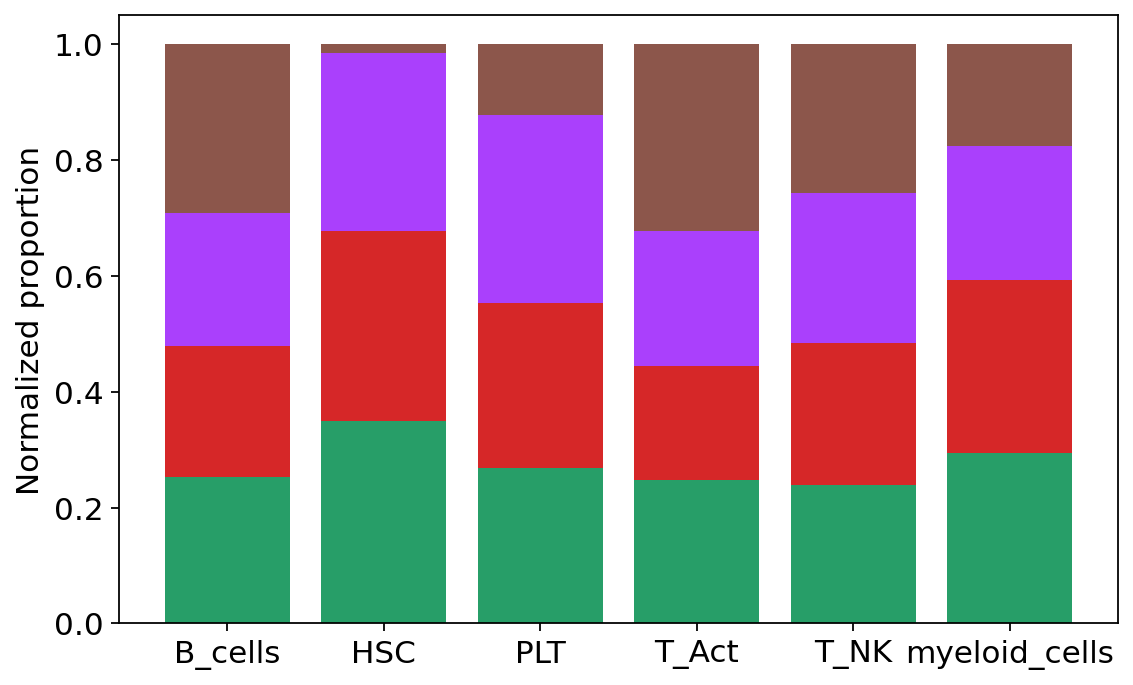

In [56]:
sctools.prop_col_chart(concat, group='cond', x='ct2', prop=True, norm=True);

In [57]:
concat.obs['ct1'].cat.categories

Index(['B_cells', 'HSC', 'PLT', 'T_Act', 'NK_T_Tox', 'T_cells', 'T_NK',
       'myeloid_cells'],
      dtype='object')

In [58]:
ct1_colors = dict(zip(concat.obs['ct1'].cat.categories, concat.uns['ct1_colors']))

In [59]:
concat.obs['ct1'] = concat.obs['ct1'].cat.reorder_categories(['B_cells', 'HSC', 'PLT', 'T_Act', 'NK_T_Tox', 'T_cells', 'T_NK', 'myeloid_cells'])
concat.uns['ct1_colors'] = [ct1_colors[ct] for ct in concat.obs['ct1'].cat.categories]

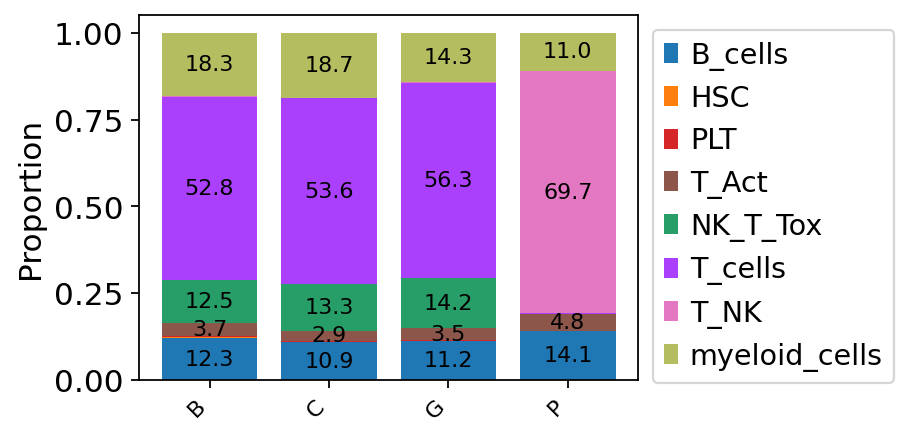

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax, df_gb = sctools.prop_col_chart(concat, group='ct1', x='cond', ax=ax, norm=False, return_df=True, prop=True, label=True, label_thresh=0.02, label_size=10);
ax.set_xticklabels(df_gb.index, rotation=45, size=10, ha='right')
ax.legend(bbox_to_anchor=(1,1));

# ax.legend().remove();
# plt.tight_layout();

# plt.savefig(prefix_figs + 'figS3/proportions_ct1_cond.pdf', dpi=300, bbox_inches=0, pad_inches=0.1);

# Rank Plots

This is a re-implementation of some functions in `sctools`.

In [61]:
def rank_plot(dge=None, xytxt=None, size=10, ax=None):
    '''
    Similar to sc.pl.rank_genes_groups(), but swaps axes and displays gene names
    horizontally. Must provide one of dge 
    
    `dge`: dge object created by get_dge
    `xytxt`: 3-tuple of lists of x values, y values, and strings of text 
             to display at each point
    `ax`: matplotlib axes object to plot on, will create if not provided
    
    returns: `ax`, matplotlib axes object
    '''
    ### THIS DOESN'T WORK FOR MULTIPLE PLOTS (i.e. sc.tl.rank_genes_groups(adata, groups=['group1', 'group2']))
    if isinstance(ax, type(None)):
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        
    if isinstance(dge, type(None)):
        x, y, txts = xytxt
    else:
        n_features = dge.shape[0]//len(dge['group'].unique())
        y = range(n_features)[::-1]
        x = dge['scores'].values
        txts = dge['names'].values
        
    ax.scatter(x, y, s=0)
    ax.barh(np.array(y) + 0.25, x, facecolor='lightgray', edgecolor='k')
    for i, txt in enumerate(txts):
        ax.annotate(txt, (x[i]*1.02, y[i]), rotation=0, size=size)
    ax.set_yticklabels([])
    ax.spines['right'].set_visible(False)
    
    return ax

In [62]:
def comparisons_rank_plots(g1, g2, label):
    concat.uns['lowde'] = dict()
    concat.uns['lowde']['groups'] = dict(zip(['g1', 'g2'], [g1, g2]))

    dge = sctools.grouped_rank(concat, key='ct1');
    plt.close()

#     ax = sctools.highlight_clust(concat, key='ct1', clusts=g1, bg_cells=(0.75, 0.75, 0.75, 1), plot_kwargs={'size': 1, 'figsize_scale': 0.5});
#     ax = sctools.highlight_clust(concat, key='ct1', clusts=g2, bg_cells=(0.75, 0.75, 0.75, 1), plot_kwargs={'size': 1, 'figsize_scale': 0.5});

    ax = rank_plot(dge.iloc[:20])
    ax.set_yticks(np.arange(0.25, 20.25, 1))
    ax.set_yticklabels(np.arange(1, 21, 1)[::-1]);
    plt.tight_layout()
#     plt.savefig(prefix_figs + 'figS3/%s_rankplot.pdf' % label, dpi=300, bbox_inches=0, pad_inches=0.1)
    return

In [63]:
g1 = ['B_cells']
g2 = ['T_cells', 'myeloid_cells']

... storing 'ct2' as categorical
/home/ssm-user/miniconda3/envs/clue_test/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


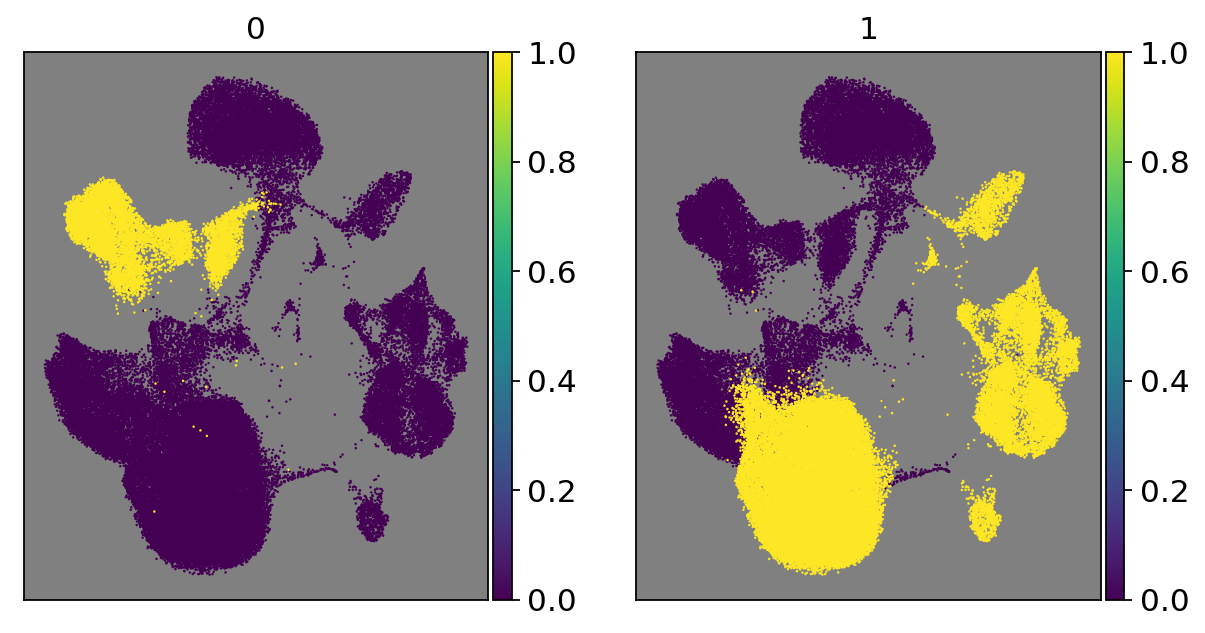

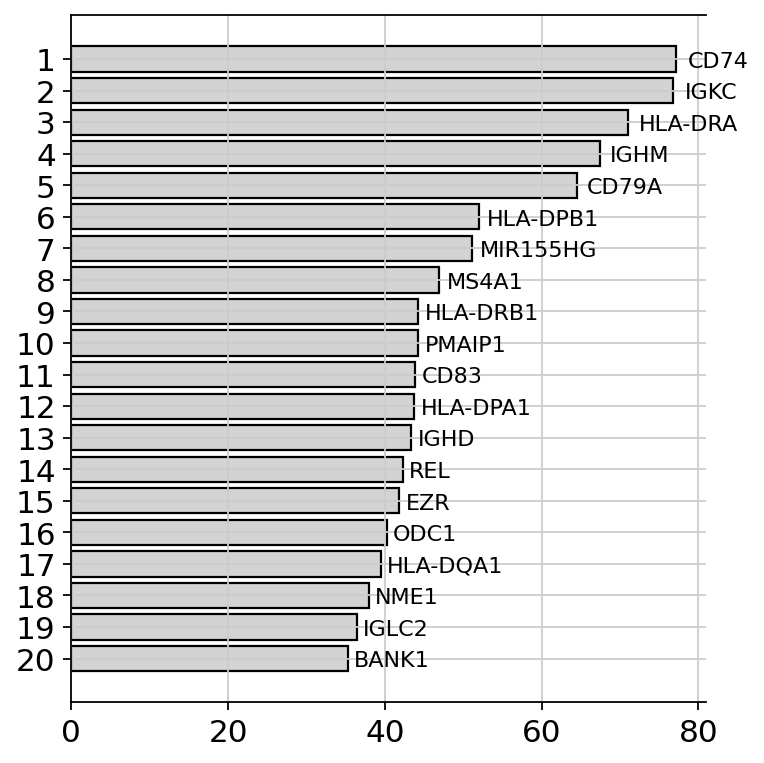

In [64]:
comparisons_rank_plots(g1, g2, label='comp1')

In [ ]:
g1 = ['T_cells']
g2 = ['B_cells', 'myeloid_cells']

In [ ]:
comparisons_rank_plots(g1, g2, label='comp2')

In [ ]:
g1 = ['myeloid_cells']
g2 = ['T_cells', 'B_cells']

In [ ]:
comparisons_rank_plots(g1, g2, label='comp3')

In [ ]:
g1 = ['NK_T_Tox']
g2 = ['T_cells']

In [ ]:
comparisons_rank_plots(g1, g2, label='comp4')

In [ ]:
g1 = ['T_Act']
g2 = ['T_cells']

In [ ]:
comparisons_rank_plots(g1, g2, label='comp5')

In [ ]:
g1 = ['T_NK']
g2 = ['T_cells', 'NK_T_Tox']

In [ ]:
comparisons_rank_plots(g1, g2, label='comp6')

# Matrixplot

In [65]:
features_dict = {
    'B_cells': ['CD74', 'IGKC', 'HLA-DRA', 'IGHM', 'CD79A', 'MS4A1', 'CD83', 'IGHD'],
    'T_cells': ['CD3E', 'CD3D', 'CD4', 'CD8A', 'CD8B', 'PTPRC', 'SELL', 'CCR7', 'CD28'],
    'NK_T_Tox': ['GNLY', 'NKG7', 'CCL5', 'CST7', 'KLRD1', 'GZMB'],
    'T_Act': ['NFKBIA', 'CD69', 'EIF1', 'KLF6', 'REL'],
    'myeloid_cells': ['TIMP1', 'CD63', 'TYROBP', 'ANXA5', 'SOD2', 'S100A11', 'FCER1G', 'LGALS3', 'CTSL'],
}
features = [i for j in features_dict.values() for i in j]

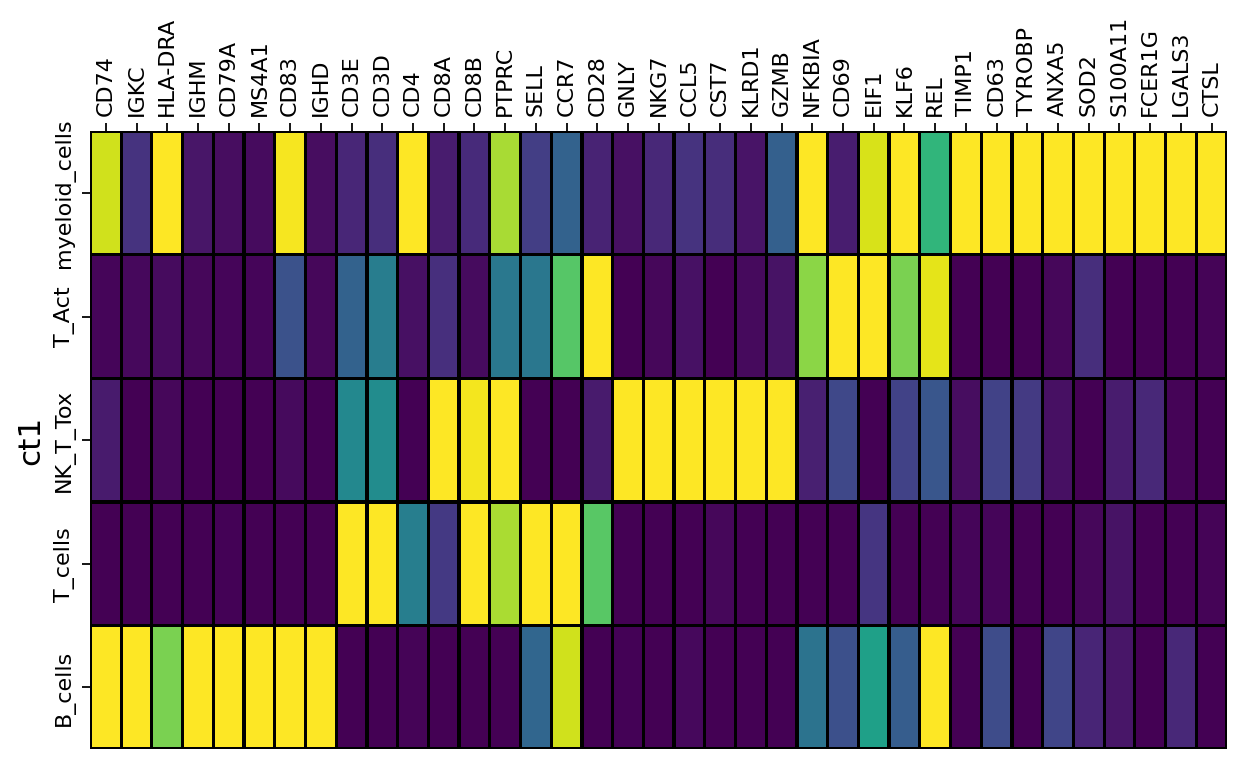

In [66]:
order = list(features_dict.keys())[::-1]
dfplot, ax = sctools.matrixplot(concat[concat.obs['ct1'].isin(features_dict.keys())], features=features, key='ct1', figsize=(8, 5),
                                plot_params={'annot': False, 'square': False}, 
                                standardize='cols', 
                                order=order
                       );
# ax.set_yticks(np.arange(dfplot.shape[0]) + 0.5)
ax.set_yticklabels(order, rotation=90, ha='right', size=10);
ax.set_xticks(np.arange(dfplot.shape[1]) + 0.5);
ax.set_xticklabels(features, rotation=90, ha='center', size=10);
plt.tight_layout()
# plt.savefig(prefix_figs + 'figS3/mrna_matrixplot.pdf', dpi=300, bbox_inches=0, pad_inches=0.1)

In [67]:
ranked_genes = dict()

In [68]:
sc.tl.rank_genes_groups(concat, groupby='cond', groups=['G'], reference='C')
ranked_genes['G'] = pd.DataFrame(concat.uns['rank_genes_groups']['names']).values.flatten()

sc.tl.rank_genes_groups(concat, groupby='cond', groups=['B'], reference='C')
ranked_genes['B'] = pd.DataFrame(concat.uns['rank_genes_groups']['names']).values.flatten()

sc.tl.rank_genes_groups(concat, groupby='cond', groups=['P'], reference='C')
ranked_genes['P'] = pd.DataFrame(concat.uns['rank_genes_groups']['names']).values.flatten()

ranking genes
    consider 'cond' groups:
    with sizes: [20126 17798]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes
    consider 'cond' groups:
    with sizes: [20409 17798]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)
ranking genes
    consider 'cond' groups:
    with sizes: [13178 17798]
    finished: added to `.uns['rank_genes_gro

In [69]:
genes = ranked_genes['G']
tf = detools.toppfun(genes)

In [70]:
tf.enrich(genes)
results = tf.results

In [71]:
cat = 'Pathway'
# cat = 'GeneOntologyBiologicalProcess'

In [72]:
sub_results = clue_utils.subsetdict(results, {'Category': cat}).copy()
sub_results['genes_enrich'] = ['|'.join(i) for i in sub_results.index.map(tf.genes_enrich)]

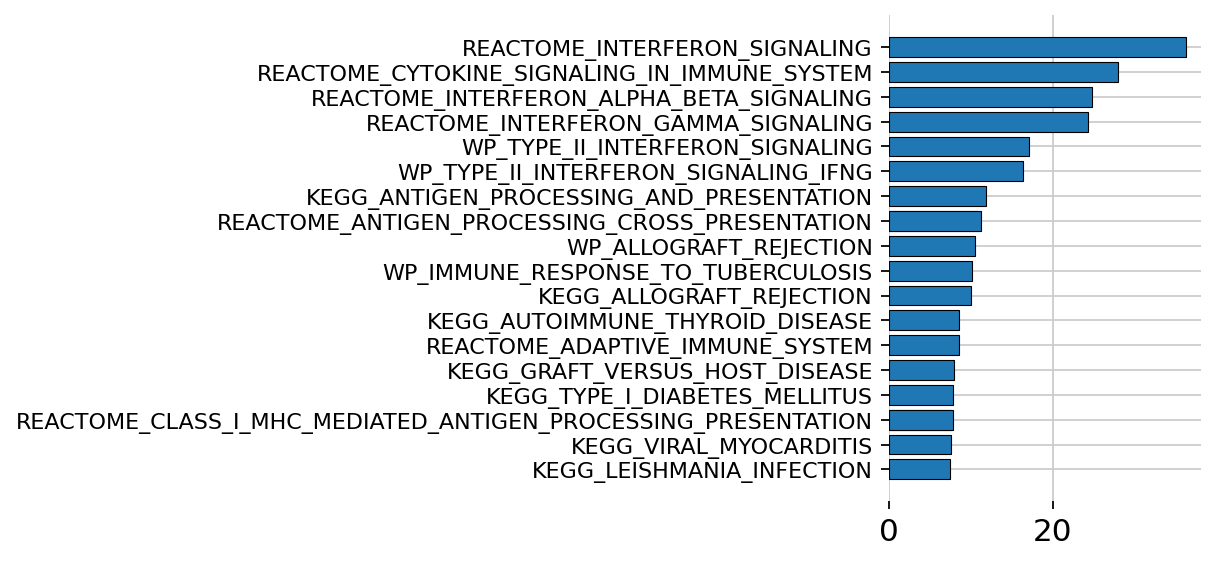

In [73]:
plt.figure(figsize=(2.5,4))
plt.barh(*sub_results[['Name', '-log10FDR']].head(20).reset_index(drop=True).values[::-1].T, 
         zorder=3, linewidth=0.5, edgecolor='k');
plt.yticks(size=10);
ax = plt.gca()
ax.set_frame_on(False)
# plt.savefig(prefix_figs + 'figS3/RNA_G_enrich.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [21]:
genes = ranked_genes['B']
tf = detools.toppfun(genes)

In [22]:
tf.enrich(genes)
results = tf.results

In [23]:
cat = 'Pathway'
# cat = 'GeneOntologyBiologicalProcess'

In [24]:
sub_results = clue_utils.subsetdict(results, {'Category': cat}).copy()
sub_results['genes_enrich'] = ['|'.join(i) for i in sub_results.index.map(tf.genes_enrich)]

In [ ]:
plt.figure(figsize=(2.5,4))
plt.barh(*sub_results[['Name', '-log10FDR']].head(20).reset_index(drop=True).values[::-1].T, 
         zorder=3, linewidth=0.5, edgecolor='k');
plt.yticks(size=10);
ax = plt.gca()
ax.set_frame_on(False)
# plt.savefig(prefix_figs + 'figS3/RNA_B_enrich.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
genes = ranked_genes['P']
tf = detools.toppfun(genes)

In [ ]:
tf.enrich(genes)
results = tf.results

In [ ]:
cat = 'Pathway'
# cat = 'GeneOntologyBiologicalProcess'

In [ ]:
sub_results = clue_utils.subsetdict(results, {'Category': cat}).copy()
sub_results['genes_enrich'] = ['|'.join(i) for i in sub_results.index.map(tf.genes_enrich)]

In [ ]:
plt.figure(figsize=(2.5,4))
plt.barh(*sub_results[['Name', '-log10FDR']].head(20).reset_index(drop=True).values[::-1].T, 
         zorder=3, linewidth=0.5, edgecolor='k');
plt.yticks(size=10);
ax = plt.gca()
ax.set_frame_on(False)
# plt.savefig(prefix_figs + 'figS3/RNA_P_enrich.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)